In [1]:
from casadi import *
import numpy as np

In [39]:
N = 200 # prediction horizon

opti = Opti() # Optimization problem

X = opti.variable(10, N+1) # state trajectory
U = opti.variable(4, N)   # control trajectory

In [40]:
f = lambda x,u: vertcat(
    x[7],
    x[8],
    x[9],
    0.5 * ( -u[1]*x[4] - u[2]*x[5] - u[3]*x[6] ),
    0.5 * (  u[1]*x[3] + u[3]*x[5] - u[2]*x[6] ),
    0.5 * (  u[2]*x[3] - u[3]*x[4] + u[1]*x[6] ),
    0.5 * (  u[3]*x[3] + u[2]*x[4] - u[1]*x[5] ),
    2 * ( x[3]*x[5] + x[4]*x[6] ) * u[0],
    2 * ( x[5]*x[6] - x[3]*x[4] ) * u[0], 
    (x[3]*x[3] - x[4]*x[4] -x[5]*x[5] + x[6]*x[6]) * u[0] - 9.81
) # dx/dt = f(x,u)

In [41]:
x_ref = opti.parameter(10, N+1)  # Reference trajectory
u_ref = opti.parameter(4, N) # Reference controls

Q = diag(MX([100, 100, 100, 10, 10, 10, 10, 10, 10, 10]))  # Weights for state error
R = diag(MX([0.1, 0.1, 0.1, 0.1]))  # Weights for control effort

cost = 0 # Cost function init
# Cost function calculations
for k in range(N):
    state_error = X[:, k] - x_ref[:, k]
    cost += mtimes(state_error.T, mtimes(Q, state_error))
    control_error = U[:, k] - u_ref[:, k]
    cost += mtimes(control_error.T, mtimes(R, control_error))

opti.minimize(cost)

In [42]:
dt = 0.1
for k in range(N):
   # Runge-Kutta 4 integration
   # Discretise
   k1 = f(X[:,k],         U[:,k])
   k2 = f(X[:,k]+dt/2*k1, U[:,k])
   k3 = f(X[:,k]+dt/2*k2, U[:,k])
   k4 = f(X[:,k]+dt*k3,   U[:,k])
   x_next = X[:,k] + dt/6*(k1+2*k2+2*k3+k4) 
   opti.subject_to(X[:,k+1]==x_next) # ensure dynamics

In [43]:
opti.subject_to(opti.bounded(2.0,U[0, :],20.0)) # control is limited
opti.subject_to(opti.bounded(-6.0,U[1, :],6.0)) # angular velocity is limited
opti.subject_to(opti.bounded(-6.0,U[2, :],6.0)) # angular velocity is limited
opti.subject_to(opti.bounded(-6.0,U[3, :],6.0)) # angular velocity is limited
opti.subject_to(X[:,0] == [1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])        # Initial state
opti.subject_to(U[:,0] == [9.81, 0.0, 0.0, 0.0])        # Initial state

In [44]:
opti.set_initial(X, 0.0) # Initial guess

# circular reference trajectory
theta = np.linspace(0, 2 * np.pi, N+1)
reference_trajectory = np.vstack((np.cos(theta), np.sin(theta), np.ones_like(theta), np.ones_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta), np.zeros_like(theta)))
opti.set_value(x_ref, reference_trajectory)

# reference controls
reference_controls = np.tile(np.array([9.81, 0.0, 0.0, 0.0]), (N, 1)).T
opti.set_value(u_ref, reference_controls)

In [45]:
opti.solver("ipopt") # set numerical backend
sol = opti.solve()   # actual solve

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19014
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     8400

Total number of variables............................:     2810
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2014
Total number of inequality constraints...............:      800
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      800
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.3924722e+04 9.81e+00 1.00e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

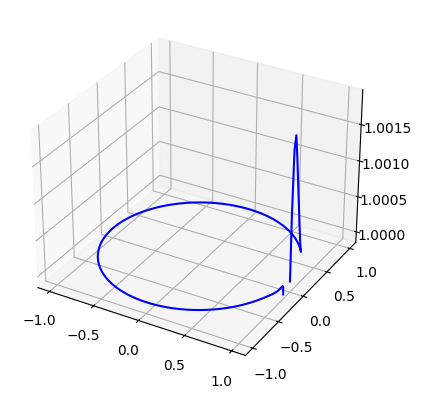

In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(sol.value(X[0, :]), sol.value(X[1, :]), sol.value(X[2, :]), label='3D Line Plot', color='blue')

plt.show()

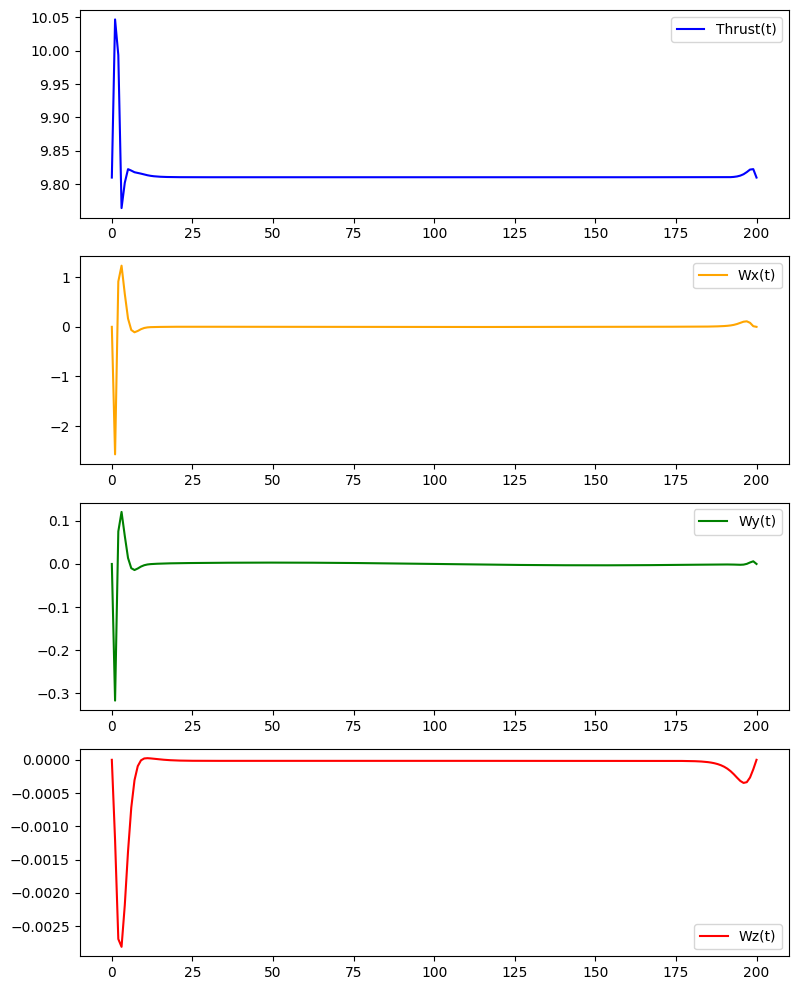

In [47]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, N, N)

fig, axs = plt.subplots(4, 1, figsize=(8, 10))

axs[0].plot(x, sol.value(U[0, :]), label="Thrust(t)", color='blue')
axs[0].legend()

axs[1].plot(x, sol.value(U[1, :]), label="Wx(t)", color='orange')
axs[1].legend()

axs[2].plot(x, sol.value(U[2, :]), label="Wy(t)", color='green')
axs[2].legend()

axs[3].plot(x, sol.value(U[3, :]), label="Wz(t)", color='red')
axs[3].legend()

plt.tight_layout()
plt.show()